<a href="https://colab.research.google.com/github/samuelflores/deep-learning-RNA-structure-prediction/blob/main/CNN_GNRA_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kernel size: 8. 
1D Convolutional layer


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import matplotlib as mpl
import sklearn

In [3]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('./drive/MyDrive/GNRA_pred/T_frames_train.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('./drive/MyDrive/GNRA_pred/labels_train.npy')
y_train = y_flt_train.astype(int)

dict_test = np.load('./drive/MyDrive/GNRA_pred/T_frames_test.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('./drive/MyDrive/GNRA_pred/labels_test.npy')
y_test = y_flt_test.astype(int)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)


Training features shape: (10749, 8, 4)
Test features shape: (5398, 8, 4)
Training labels shape: (10749,)
Test labels shape: (5398,)


In [4]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [5]:
neg, pos = np.bincount(y_train)+np.bincount(y_test)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)


Examples:
    Total: 16147
    Positive: 9931 (61.50% of total)

Training labels shape: (10749,)
Test labels shape: (5398,)
Training features shape: (10749, 8, 4)
Test features shape: (5398, 8, 4)


In [15]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(16, 3, strides=1, activation='relu',padding='same', 
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    Dropout(0.2),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(1, activation='sigmoid')  #Sigmoid for binary question.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)
  
  return model


In [37]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  # plt.semilogy(history.epoch, history.history['val_loss'],
              #  color=colors[n], label='Val ' + label,
              #  linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [19]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [45]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    # plt.plot(history.epoch, history.history['val_' + metric],
            #  color=colors[0], linestyle="--", label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [21]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [22]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall  - TP / (TP + FP)')
    plt.ylabel('Precision - TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [23]:
# retrain with class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.30
Weight for class 1: 0.81


In [52]:
weighted_model = make_model()
#weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    x_train,
    y_train, 
    # validation_data = (x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight={0: 1.30, 1: 0.81})

Epoch 1/20
672/672 [==============================] - 4s 3ms/step - loss: 0.2430 - tp: 9231.0000 - fp: 472.0000 - tn: 5744.0000 - fn: 700.0000 - accuracy: 0.9274 - precision: 0.9514 - recall: 0.9295 - auc: 0.9801 - prc: 0.9861
Epoch 2/20
672/672 [==============================] - 2s 3ms/step - loss: 0.1158 - tp: 6382.0000 - fp: 159.0000 - tn: 3970.0000 - fn: 238.0000 - accuracy: 0.9631 - precision: 0.9757 - recall: 0.9640 - auc: 0.9903 - prc: 0.9931
Epoch 3/20
672/672 [==============================] - 2s 3ms/step - loss: 0.1003 - tp: 6422.0000 - fp: 152.0000 - tn: 3977.0000 - fn: 198.0000 - accuracy: 0.9674 - precision: 0.9769 - recall: 0.9701 - auc: 0.9928 - prc: 0.9947
Epoch 4/20
672/672 [==============================] - 2s 3ms/step - loss: 0.0873 - tp: 6471.0000 - fp: 132.0000 - tn: 3997.0000 - fn: 149.0000 - accuracy: 0.9739 - precision: 0.9800 - recall: 0.9775 - auc: 0.9943 - prc: 0.9957
Epoch 5/20
672/672 [==============================] - 2s 3ms/step - loss: 0.0811 - tp: 6472.

KeyError: ignored

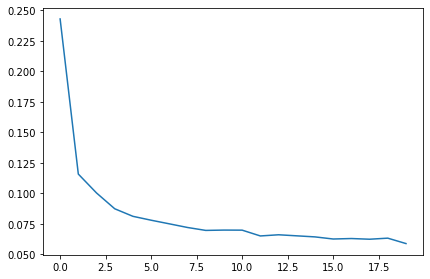

In [53]:
plot_metrics(weighted_history)

In [54]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)

loss :  0.06547720730304718
tp :  3254.0
fp :  52.0
tn :  2035.0
fn :  57.0
accuracy :  0.9798073172569275
precision :  0.9842710494995117
recall :  0.982784628868103
auc :  0.996353268623352
prc :  0.9975423216819763

Not Contacts Detected (True Negatives):  2035
Not Contacts Incorrectly Detected (False Positives):  52
Contacts Missed (False Negatives):  57
Contacts Detected (True Positives):  3254
Total Contacts:  3311


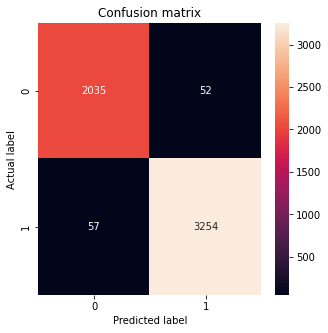

In [55]:
# Results of test data set. 
weighted_results = weighted_model.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

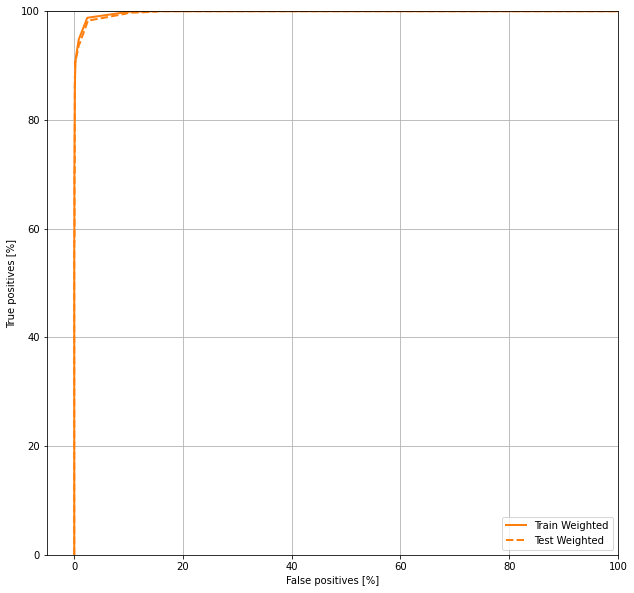

In [56]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

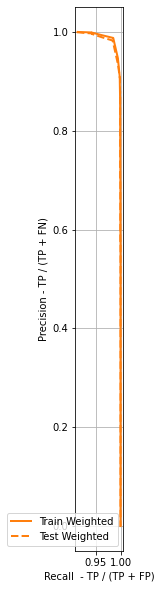

In [57]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

In [20]:
# Model with three convolutional and one fully connected layer.
model = Sequential()

model.add(Conv1D(16, 3, strides=1,
                 activation='relu', padding='same', 
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, strides=1,
                 activation='relu', padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy())

model.summary()
history = model.fit(
    x_train, y_train, validation_data = (x_test, y_test), epochs=EPOCHS, 
    batch_size=BATCH_SIZE, shuffle=True)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 8, 16)             208       
                                                                 
 dropout_15 (Dropout)        (None, 8, 16)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 32)             1568      
                                                                 
 dropout_16 (Dropout)        (None, 8, 32)             0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 32)            0         
 1D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 4, 32)             0         
                                                      